In [13]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re, string
import pickle
from sklearn.externals import joblib
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from score import calc_auc_score, calc_log_loss
import matplotlib.pyplot as plt

## Take Input

In [7]:
# read the train and test data
def readInputFiles(train_file_path, test_file_path):
    train = pd.read_csv(train_file_path)
    test = pd.read_csv(test_file_path)
    return train, test
    
train, test = readInputFiles('./dataset/train_new.csv', './dataset/test_new.csv')

## Data Exploration

Grandma Terri Should Burn in Trash 
Grandma Terri is trash. I hate Grandma Terri. F%%K her to HELL! 71.74.76.40

Average length of comments: 395
Standard dev: 593
Longest Comment: 5000

# Comments in train data: 127656 
# Comments in test data: 31915


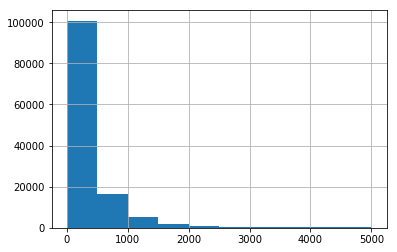

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length
0,140030,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0,111
1,159124,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0,502
2,60006,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0,4573
3,65432,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0,36
4,154979,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0,243


In [15]:
def dataExploration(trainData):   
    # look at the top five rows of the train data file
    # training data contains a row per comment, with an id, 
    # the text of the comment, and 6 different labels
    trainData.head()
    
    # exampel of a comment in the train data
    print (trainData['comment_text'][0])
    print ("")
    
    # the length of the comments varies a lot   
    lens = trainData.comment_text.str.len()
    print("Average length of comments: %d\nStandard dev: %d\nLongest Comment: %d" % (lens.mean(), lens.std(), lens.max()))
    
    print ("")
    print ("# Comments in train data: %d \n# Comments in test data: %d" % (len(train),len(test)))
    lens.hist()
    plt.show()
    
dataExploration(train)
train.head()

# Comment Length

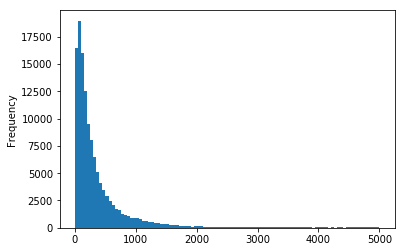

In [16]:
train['length'] = train['comment_text'].apply(len)
train['length'].plot(bins=100, kind="hist")
plt.show()

# Comment Length vs Toxic Class

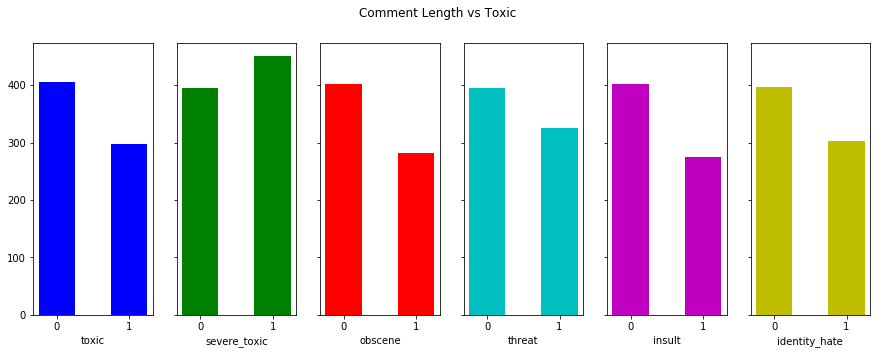

In [20]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

colors = ('b','g','r','c','m','y')

f, axes = plt.subplots(1, 6, sharey=True, figsize=(15,5))
f.suptitle('Comment Length vs Toxic')

for i, label in enumerate(labels):
    
    data = train.groupby(label).mean()['length']
    
    axes[i].bar(data.index.values, data, width=0.5, color=colors[i])
    
    axes[i].set_xlabel(label)
    
plt.show()

In [22]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation plot of toxic behaviors', y=1.05, size=15)
sns.heatmap(train_[['toxicity_label','toxic','severe_toxic','obscene','threat','insult','identity_hate']].astype(float).corr(),linewidths=0.1,
            vmax=1.0, square=True, cmap=colormap, linecolor='white',
            annot=True)

NameError: name 'sns' is not defined